# Load some extra focal samples into training set
The audio files used so far are the first instance of an individual's call within a time period, and these aren't necessarily the loudest or clearest calls. The loudest and clearest calls will often get overlooked during a wildtrax tagging methods 1SPM 1 sample per minute or 1SPT 1 sample per time interval.

The HawkEars model was used to go through and pick out these more focal vocalizations from later in the recordings.

This notebook aims to test the effect of using these more focal recordings for training. The hypothesis is that by increasing the number of focal recordings of the present class, the model will be able to learn more easily and will converge faster, which will result in more stable training. 

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
# imports
from pathlib import Path
import sys
import pandas as pd
BASE_PATH = Path.cwd().parent.parent
sys.path.append(str(BASE_PATH))
from src.utils import display_all, plot_locations, keep_cols, show_sample_from_df
import src.data
import src.data.build
import opensoundscape as opso
from opensoundscape.preprocess.utils import show_tensor, show_tensor_grid
import hashlib
model_save_path = BASE_PATH / 'models'

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/ml/cnn.py:18: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# # load the raw data
data_path = Path.cwd().parent.parent / "data"
focal_recs = pd.read_pickle(data_path / "interim" / "train_and_valid_set" / "focal_osfls_thresh_1.0_ngen_194.pkl")
# train_df_path = Path.cwd().parent.parent / "data" / "interim" / "train_and_valid_set"
# df_train = pd.read_pickle(train_df_path / "train_and_valid_set.pkl")

In [4]:
focal_recs.head()

recording_id  \
file                                               start_time end_time                 
../../data/raw/recordings/OSFL/recording-555135... 40.5       43.5            555135   
                                                   42.0       45.0            555135   
../../data/raw/recordings/OSFL/recording-255457... 4.5        7.5             255457   
                                                   73.5       76.5            255457   
                                                   96.0       99.0            255457   

                                                                       label  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 40.5       43.5      OSFL   
                                                   42.0       45.0      OSFL   
../../data/raw/recordings/OSFL/recording-255457... 4.5        7.5       OSFL   
                                                   73.5       76.5      OSFL   
                                                   96.0       99.0      OSFL   

                                                                       score  \
file                                               start_time end_time         
../../data/raw/recordings/OSFL/recording-555135... 40.5       43.5      1.00   
                                                   42.0       45.0      1.00   
../../data/raw/recordings/OSFL/recording-255457... 4.5        7.5       1.00   
                                                   73.5       76.5      1.00   
                                                   96.0       99.0      1.00   

                                                                       file_extension  \
file                                               start_time end_time                  
../../data/raw/recordings/OSFL/recording-555135... 40.5       43.5               flac   
                                                   42.0       45.0               flac   
../../data/raw/recordings/OSFL/recording-255457... 4.5        7.5                 mp3   
                                                   73.5       76.5                mp3   
                                                   96.0       99.0                mp3   

                                                                        duration  
file                                               start_time end_time            
../../data/raw/recordings/OSFL/recording-555135... 40.5       43.5           3.0  
                                                   42.0       45.0           3.0  
../../data/raw/recordings/OSFL/recording-255457... 4.5        7.5            3.0  
                                                   73.5       76.5           3.0  
                                                   96.0       99.0           3.0

In [5]:
# Load the human labelled train and validation data

train_df = pd.read_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
valid_df = pd.read_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

In [6]:
train_df.head().head()

target_absence  \
file                                              start_time end_time                   
../../data/raw/recordings/OSFL/recording-4396.mp3 0.0        3.0                  1.0   
                                                  1.5        4.5                  1.0   
                                                  3.0        6.0                  1.0   
                                                  4.5        7.5                  1.0   
                                                  6.0        9.0                  1.0   

                                                                       target_presence  
file                                              start_time end_time                   
../../data/raw/recordings/OSFL/recording-4396.mp3 0.0        3.0                   0.0  
                                                  1.5        4.5                   0.0  
                                                  3.0        6.0                   0.0  
                                                  4.5        7.5                   0.0  
                                                  6.0        9.0                   0.0

# Split the focal recordings into training and validation sets in accordance with the current train/valid splits saved to disk
- this is to keep the training and validation data from separate recording locations. 

Convert the focal df index to Path objects for comparison to the train and valid df index

In [7]:
# Convert the focal df index to Path objects
new_index = focal_recs.index.set_levels(focal_recs.index.levels[0].map(Path), level=0)


In [8]:
focal_recs.index = new_index

In [9]:
train_df_file_paths = train_df.index.get_level_values('file')
valid_df_file_paths = valid_df.index.get_level_values('file')
focal_recs_file_paths = focal_recs.index.get_level_values('file')

train_focal_recs_idx = focal_recs_file_paths.isin(train_df_file_paths)
valid_focal_recs_idx = focal_recs_file_paths.isin(valid_df_file_paths)

train_focal = focal_recs[train_focal_recs_idx]
valid_focal = focal_recs[valid_focal_recs_idx]

Combine the train dataframe and the focal training recordings. 

In [10]:
i=0

In [11]:
# drop some positive classes from the training set - this is so that when we downsample and balance the dataframes later we don't throw out the focal samples. 
downsampled_train_df = train_df.loc[train_df.target_presence == 1.0].sample(frac = 0.1)


In [12]:
# concat the train and focal dataframes
focal_recs["target_presence"] = 1.0
focal_recs["target_absence"] = 0.0
df_train_and_focal = pd.concat([downsampled_train_df, focal_recs[['target_absence', 'target_presence']]], axis=0)
# drop duplicates and keep ones from hawkears
duplicates = df_train_and_focal.index.duplicated(keep='last') 
df_train_and_focal = df_train_and_focal.drop(df_train_and_focal.index[duplicates])

In [13]:
i=0

In [14]:
df_train_and_focal

,,,target_absence,target_presence
file,start_time,end_time,,
../../data/raw/recordings/OSFL/recording-557838.flac,6.0,9.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-296812.mp3,0.0,3.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-255582.mp3,43.5,46.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-292286.mp3,21.0,24.0,0.0,1.0
../../data/raw/recordings/OSFL/recording-292897.mp3,3.0,6.0,0.0,1.0
...,...,...,...,...
../../data/raw/recordings/OSFL/recording-292243.mp3,91.5,94.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-816829.flac,61.5,64.5,0.0,1.0
../../data/raw/recordings/OSFL/recording-555713.flac,0.0,3.0,0.0,1.0


In [15]:
i=0

../../data/raw/recordings/OSFL/recording-538292.flac 58.5 61.5


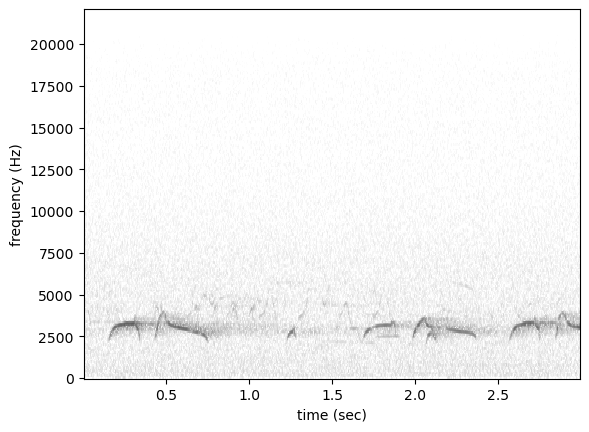

In [16]:
show_sample_from_df(df_train_and_focal[-100:], i)
i+=1

In [17]:
train_df.head()

target_absence  \
file                                              start_time end_time                   
../../data/raw/recordings/OSFL/recording-4396.mp3 0.0        3.0                  1.0   
                                                  1.5        4.5                  1.0   
                                                  3.0        6.0                  1.0   
                                                  4.5        7.5                  1.0   
                                                  6.0        9.0                  1.0   

                                                                       target_presence  
file                                              start_time end_time                   
../../data/raw/recordings/OSFL/recording-4396.mp3 0.0        3.0                   0.0  
                                                  1.5        4.5                   0.0  
                                                  3.0        6.0                   0.0  
                                                  4.5        7.5                   0.0  
                                                  6.0        9.0                   0.0

# Log some hyperparameters

In [18]:
n_samples_per_class = 600
one_output_neuron = False
random_seed = 3
positive_index = 1

In [19]:
# train_dataset, valid_dataset, _, _ = src.data.build.dataset_from_df(df_train, target_species = "OSFL", download_n=0, seed=random_seed)

In [20]:
# train_df = train_dataset.label_df
# valid_df = valid_dataset.label_df

# train_df.to_pickle(data_path / "interim" / "train_set" / "train_df.pkl")
# valid_df.to_pickle(data_path / "interim" / "valid_set" / "valid_df.pkl")

The random seed sets the deterministic splitting of the training and validation set. Here we can check whether the splits have changed from one run to the next. 

In [21]:
# Convert the DataFrame to a hashable string
# This involves hashing each row, then concatenating the hashes, and finally hashing the concatenated hash.
train_string_to_hash = ''.join(pd.util.hash_pandas_object(train_df, index=False).astype(str))
valid_string_to_hash = ''.join(pd.util.hash_pandas_object(valid_df, index=False).astype(str))


# Use hashlib to create a hash of the entire DataFrame
train_hash_value = hashlib.sha256(train_string_to_hash.encode()).hexdigest()
valid_hash_value = hashlib.sha256(valid_string_to_hash.encode()).hexdigest()
print(train_hash_value, valid_hash_value)
assert train_hash_value == "28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2", "Training set has changed"
assert valid_hash_value == "7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe", "Validation set has changed"

28029fc6efcdec044c3d4e7c9412a882bbfc680b33c966290529f7ed8c5956b2 7ae7ebc16edad82fdc43102630d180e6fa3b4a32e44a0cc64ca70ab68ec0d1fe


In [22]:
train_df.target_presence.value_counts(), valid_df.target_presence.value_counts()

(target_presence
 0.0    45081
 1.0     4211
 Name: count, dtype: int64,
 target_presence
 0.0    9947
 1.0    1043
 Name: count, dtype: int64)

In [23]:
from opensoundscape.data_selection import resample

# upsample (repeat samples) or downsample so that both classes have equal numbers of samples
balanced_train_df = resample(train_df,n_samples_per_class=n_samples_per_class,random_state=random_seed)
balanced_valid_df = resample(valid_df,n_samples_per_class=500,random_state=random_seed)

In [24]:
balanced_train_df.target_presence.value_counts(), len(balanced_train_df)

(target_presence
 0.0    600
 1.0    600
 Name: count, dtype: int64,
 1200)

In [25]:
def last_clip(df, idx):
    '''
    show last clip from a recording in dataframe with multi index.
    '''
    path = df.index[idx][0]
    return df.loc[path].iloc[-1].name[1]

def show_sample(df, idx):
    print(f"Present label: {df.iloc[idx].target_presence}")
    print(f"Last clip: {last_clip(df, idx)}")
    show_sample_from_df(df, idx)
    idx += 1
    return idx

In [26]:
idx=0

In [27]:
shuffled_balanced_train_df = balanced_train_df.sample(frac = 1)
shuffled_balanced_valid_df = balanced_valid_df.sample(frac = 1)

Present label: 0.0
Last clip: 43.5
../../data/raw/recordings/OSFL/recording-292857.mp3 64.5 67.5


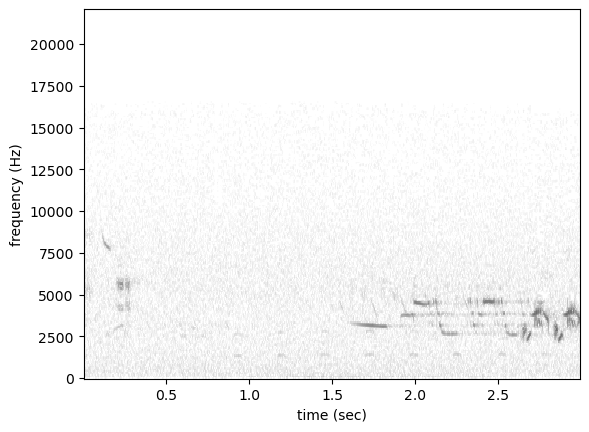

In [28]:
show_sample(shuffled_balanced_train_df, idx)
idx += 1

In [29]:
balanced_train_df.columns, balanced_valid_df.columns

(Index(['target_absence', 'target_presence'], dtype='object'),
 Index(['target_absence', 'target_presence'], dtype='object'))

In [30]:
# Create a CNN object designed to recognize 3-second samples
from opensoundscape import CNN

# Use resnet18 or resnet34 architecture
architecture = 'resnet34'

# Can use this code to get your classes, if needed
class_list = list(balanced_train_df.columns)

model = CNN(
    architecture = architecture,
    classes = class_list,
    sample_duration=3,
)
# Single target means that the label can't be present and absent simultaneously. For multi class problems this could be set to true, but for a binary problem it should be false.
model.single_target = True


In [31]:
model.network.fc

Linear(in_features=512, out_features=2, bias=True)

In [32]:
class_list

['target_absence', 'target_presence']

In [33]:
def show_sample_from_df(present=True, df = balanced_train_df):
    if present:
        present = 1
    else: 
        present = 0
    sample = df.loc[df.target_presence == present].sample()
    path, offset, end_time = sample.index[0]
    duration = end_time - offset
    audio = opso.Audio.from_file(path, offset=offset, duration=duration)
    spec = opso.Spectrogram.from_audio(audio)
    audio.show_widget()
    spec.plot()


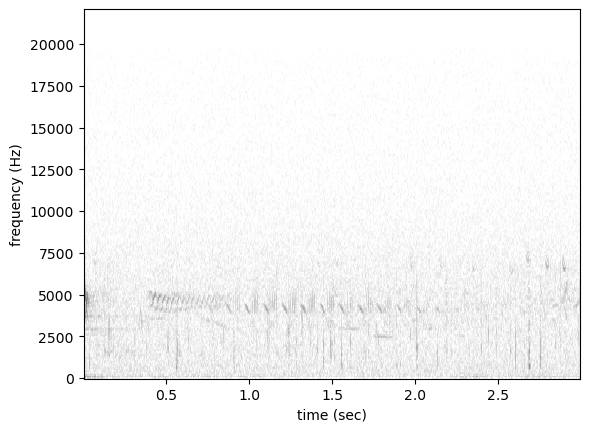

In [34]:
show_sample_from_df(present=True)

In [35]:
print(f'model.device is: {model.device}')

model.device is: mps


In [36]:
%set_env WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"

env: WANDB_NOTEBOOK_NAME="1.15.1-mjg-osfl-revisit-opso-training-cycle"


# Weights and biases initialization

In [37]:
import wandb
wandb.login()

wandb_session = wandb.init(

    project='OSFL',
    config={
    "epochs":8,
    "n_samples_per_class": n_samples_per_class,
    "one_output_neuron": one_output_neuron,
    "random_seed": random_seed,
    "positive_index": positive_index,
    "balanced_valid_set": True,
    }
)


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find "1.15.1-mjg-osfl-revisit-opso-training-cycle".
wandb: Currently logged in as: mgallimore88. Use `wandb login --relogin` to force relogin
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [38]:
shuffled_balanced_valid_df.value_counts()

target_absence  target_presence
0.0             1.0                500
1.0             0.0                500
Name: count, dtype: int64

In [39]:
model.train(
    balanced_train_df,
    balanced_valid_df,
    epochs = 4,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 0


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 0 [batch 0/19, 0.00%] 
	DistLoss: 0.731
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 1


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 1 [batch 0/19, 0.00%] 
	DistLoss: 0.758
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 2


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 2 [batch 0/19, 0.00%] 
	DistLoss: 0.690
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 3


  0%|          | 0/19 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 3 [batch 0/19, 0.00%] 
	DistLoss: 0.692
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 0 with Validation score 0.667.


In [40]:
model.train(
    balanced_train_df,
    balanced_valid_df,
    epochs = 8,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 4


  0%|          | 0/19 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 4 [batch 0/19, 0.00%] 
	DistLoss: 0.802
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 5


  0%|          | 0/19 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 5 [batch 0/19, 0.00%] 
	DistLoss: 0.703
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 6


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 6 [batch 0/19, 0.00%] 
	DistLoss: 0.700
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 7


  0%|          | 0/19 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 7 [batch 0/19, 0.00%] 
	DistLoss: 0.708


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 8


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 8 [batch 0/19, 0.00%] 
	DistLoss: 0.693
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 9


  0%|          | 0/19 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 9 [batch 0/19, 0.00%] 
	DistLoss: 0.691
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 10


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 10 [batch 0/19, 0.00%] 
	DistLoss: 0.694
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 11


  0%|          | 0/19 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 11 [batch 0/19, 0.00%] 
	DistLoss: 0.741
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Best Model Appears at Epoch 4 with Validation score 0.667.


In [41]:
model.train(
    balanced_train_df,
    balanced_valid_df,
    epochs = 4,
    batch_size = 64,
    num_workers = 4, #4 parallelized cpu tasks for preprocessing
    log_interval = 100,
    save_interval = 10,
    wandb_session = wandb_session,
    )


Training Epoch 12


  0%|          | 0/19 [00:00<?, ?it/s]

Epoch: 12 [batch 0/19, 0.00%] 
	DistLoss: 0.773
Metrics:


/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
wandb: Network error (ConnectionError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Network error (TransientError), entering retry loop.
wandb: Netw

Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

Metrics:

Training Epoch 13


  0%|          | 0/19 [00:00<?, ?it/s]

/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)
/Users/mikeg/miniforge3/envs/osfl2/lib/python3.10/site-packages/opensoundscape/audio.py:340: UserWarning: Audio object is shorter than requested duration: 2.8619727891156463 sec instead of 3.0 sec
  warnings.warn(error_msg)


Epoch: 13 [batch 0/19, 0.00%] 
	DistLoss: 0.689
Metrics:
Metrics:

Validation.


  0%|          | 0/16 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 24857) exited unexpectedly